## Historic Drought Analysis

This notebook steps through an analysis of droughts in the DRB, assessing droughts using multiple different metrics including:
- Exceedance probability
- Severity
- Duration

Droughts are classified using the Standardized Streamflow Index (SSI).

In [1]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scipy.stats as scs
import spei as si
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sys.path.insert(0, '../')

from methods.diagnostics.drought import get_drought_metrics, calculate_ssi_values
from methods.plotting import plot_ssi
from methods.plotting.styles import model_colors

from methods.processing import transform_results_dict_flow
from methods.processing.load import load_historic_datasets
from methods.utils.lists import drbc_droughts
from methods.utils.constants import crs
from methods.utils.directories import data_dir, fig_dir



# Directory to pywrdrb project
pywrdrb_directory = '../../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches, upstream_nodes_dict
from pywrdrb.utils.lists import majorflow_list, reservoir_list


# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')
nyc_reservoirs = ['cannonsville', 'pepacton', 'neversink']

model_names = ['obs', 'nhmv10', 'nwmv21', 
               'obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled',
               'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']


# Aesthetics for plotting
model_colors = {
    'obs': 'black',
    'nhmv10' : '#925736', 
    'nwmv21' : '#385723',
    'obs_pub_nhmv10' : '#F27300',
    'obs_pub_nhmv10_ObsScaled': '#F27300', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nhmv10_ObsScaled_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#9CD2F6',
    'obs_pub_nwmv21_ObsScaled' : '#0174BE', 
    'obs_pub_nwmv21_ObsScaled_ensemble': '#9CD2F6'
    }

model_labels = {
    'obs': 'Observed',
    'nhmv10' : 'NHMv1.0',
    'nwmv21' : 'NWMv2.1',
    'obs_pub_nhmv10' : 'PUB-NHM',
    'obs_pub_nhmv10_ensemble' : 'PUB-NHM Ensemble',
    'obs_pub_nwmv21' : 'PUB-NWM',
    'obs_pub_nwmv21_ensemble':'PUB-NWM Ensemble',
    'obs_pub_nhmv10_ObsScaled' : 'PUB-NHM',
    'obs_pub_nhmv10_ObsScaled_ensemble' : 'PUB-NHM Ensemble',
    'obs_pub_nwmv21_ObsScaled' : 'PUB-NWM',
    'obs_pub_nwmv21_ObsScaled_ensemble':'PUB-NWM Ensemble'
    }


In [2]:
### LOAD DATA
Q = load_historic_datasets(models=model_names)

# Load spatial data
drb_boundary = gpd.GeoDataFrame.from_file(f'{pywrdrb_directory}/DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
node_geoms = gpd.read_file(f'{pywrdrb_directory}/DRB_spatial/DRB_shapefiles/node_basin_geometries.shp').to_crs(crs)



Loading obs...
Loading nhmv10...
Loading nwmv21...
Loading obs_pub_nhmv10_ObsScaled...
Loading obs_pub_nwmv21_ObsScaled...
Loading obs_pub_nhmv10_ObsScaled_ensemble...
Loading obs_pub_nwmv21_ObsScaled_ensemble...


In [3]:
def transform_flow(data, transform = 'rolling', window = None, 
                   aggregation_type = 'mean', aggregation_length = None):
    """Transforms a single dataframe of flow data using pandas rolling or
    reample methods.
    """
    assert(transform in ['rolling', 'aggregation']), 'transform must be rolling or aggregation'
    assert(aggregation_type in ['mean', 'sum']), 'aggregation_type must be mean or sum'
    assert((window is not None) or (aggregation_length is not None)), 'window or aggregation_length must be specified'
    transformed_data = 0
    if transform == 'rolling':
        if aggregation_type == 'mean':
            transformed_data = data.rolling(window=window).mean()
        elif aggregation_type == 'sum':
            transformed_data = data.rolling(window=window).sum()
        transformed_data = transformed_data.iloc[window-1:].dropna()
    elif transform == 'aggregation':
        if aggregation_type == 'mean':
            transformed_data = data.resample(aggregation_length).mean()
        elif aggregation_type == 'sum':
            transformed_data = data.resample(aggregation_length).sum()
    return transformed_data


def transform_ensemble_flow(data, transform, window, 
                            aggregation_type, aggregation_length):
    """Transforms an ensemble of data one key/dataframe at a time.
    """
    ensemble_transformed_data = {}
    for key in data.keys():
        ensemble_transformed_data[key] = transform_flow(data[key], transform, window, 
                                   aggregation_type, aggregation_length)
    return ensemble_transformed_data


def transform_results_dict_flow(data, transform, window, 
                                aggregation_type, aggregation_length):
    """Transforms a dictionary of results dataframes with flow data.
    """
    assert(type(data) == dict), 'data must be a dictionary'
    assert(transform in ['rolling', 'aggregation']), 'transform must be rolling or aggregation'
    
    transformed_data_dict= {}
    for key in data.keys():
        print(f'Transforming {key} flow')
        if 'ensemble' in key:
            transformed_data_dict[key] = transform_ensemble_flow(data[key], transform, window, 
                                                aggregation_type, aggregation_length)
        else:
            transformed_data_dict[key] = transform_flow(data[key], transform, window, 
                                    aggregation_type, aggregation_length)
    return transformed_data_dict

In [4]:
### Get SSI values
## Aggregate flows
Q_monthly = transform_results_dict_flow(Q.copy(), transform = 'aggregation',  window=1,
                       aggregation_type = 'sum', aggregation_length='M')

ssi_window = int(12)
ssi_d = calculate_ssi_values(Q_monthly, window=ssi_window, nodes=['delTrenton'])


Transforming obs flow
Transforming nhmv10 flow
Transforming nwmv21 flow
Transforming obs_pub_nhmv10_ObsScaled flow
Transforming obs_pub_nwmv21_ObsScaled flow
Transforming obs_pub_nhmv10_ObsScaled_ensemble flow
Transforming obs_pub_nwmv21_ObsScaled_ensemble flow
Calculating SSI for obs...
Calculating SSI for nhmv10...
Calculating SSI for nwmv21...
Calculating SSI for obs_pub_nhmv10_ObsScaled...
Calculating SSI for obs_pub_nwmv21_ObsScaled...
Calculating SSI for obs_pub_nhmv10_ObsScaled_ensemble...
Calculating SSI for obs_pub_nwmv21_ObsScaled_ensemble...


In [5]:
def subplot_drbc_drought_events(ax, start_date, end_date, 
                                event_colors = None,
                                drbc_droughts=drbc_droughts,
                                legend = False):
    # Define colors for different event types
    if event_colors is None:
        event_colors = {'Watch': 'gold', 
                        'Warning': 'peru', 
                        'Emergency': 'saddlebrown'}

    ## DRBC-classified drought events
    # Iterate through the events and create colored bars
    for index, row in drbc_droughts.iterrows():
        color = event_colors[row['event_type']]
        start_date = pd.to_datetime(row['start_date'])
        end_date = pd.to_datetime(row['end_date'])
        ax.axvspan(start_date, end_date, facecolor=color, edgecolor='none', alpha=1, lw=0.0)

    # Adding legend for the event types
    if legend:
        handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
        ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1), 
                title='Event Type', title_fontsize=10, fontsize=8, alignment='left')

    ax.set_yticks([])
    return ax


def get_drought_days(ssi):
    # Classify droughts
    in_critical_drought = False
    droughts = np.zeros_like(ssi.values)
    drought_days = []
    for ind in range(len(droughts)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
            
        else:
            if in_critical_drought:
                droughts[drought_days] =1
            in_critical_drought = False
            drought_days = [] 
    
    # Handle edge case
    if in_critical_drought:
        droughts[drought_days] =1
    return droughts



def get_ensemble_drought_days(ensemble_ssi, node, start_date, end_date):
    
    realizations = list(ensemble_ssi.keys())
    n_realizations = len(realizations)
    
    drought_days = np.zeros((n_realizations, len(ensemble_ssi[realizations[0]].loc[start_date:end_date, node])))
    for i, realization in enumerate(realizations):
        ssi = ensemble_ssi[realization].loc[start_date:end_date, node]
        drought_days[i, :] = get_drought_days(ssi)
    return drought_days
        
get_ensemble_drought_days(ssi_d['obs_pub_nhmv10_ObsScaled_ensemble'], 'delTrenton', '1964-01-01', '1964-12-31')


def get_fraction_of_ensemble_in_drought(ensemble_ssi, node, start_date, end_date):
    realizations = list(ensemble_ssi.keys())
    n_realizations = len(realizations)
    
    drought_days = get_ensemble_drought_days(ensemble_ssi, node, start_date, end_date)
    print(drought_days.shape)
    fraction_in_drought = np.sum(drought_days, axis=0)/n_realizations
    return fraction_in_drought

fd = get_fraction_of_ensemble_in_drought(ssi_d['obs_pub_nhmv10_ObsScaled_ensemble'], 'delTrenton', '1964-01-01', '1964-12-31')


def modify_cmap_zero_to_white(original_cmap_name):
    # Get the original colormap
    original_cmap = plt.cm.get_cmap(original_cmap_name)

    # Copy the colormap's colors and modify the first color (0 value) to white
    modified_colors = original_cmap(np.arange(original_cmap.N))
    modified_colors[0, :] = [1, 1, 1, 1]  # RGBA for white

    # Create a new colormap from the modified colors
    modified_cmap = mcolors.ListedColormap(modified_colors)

    return modified_cmap

def create_mirrored_cmap(cmap_name):
    original_cmap = plt.cm.get_cmap(cmap_name)
    reversed_cmap = original_cmap.reversed()
    combined_colors = np.vstack((original_cmap(np.linspace(0, 1, 128)),
                                 reversed_cmap(np.linspace(0, 1, 128))))
    mirrored_cmap = mcolors.LinearSegmentedColormap.from_list('mirrored_' + cmap_name, combined_colors)
    return mirrored_cmap



def clean_xtick_labels(axes, start_date, end_date, 
                       fontsize=10, date_format='%Y', 
                       max_ticks=10, rotate_labels=False):
    """
    Clean up x-axis tick labels for time series data.
    """
    try:
        start_date = pd.to_datetime(start_date) if isinstance(start_date, str) else start_date
        end_date = pd.to_datetime(end_date) if isinstance(end_date, str) else end_date

        if start_date >= end_date:
            raise ValueError(f"Start date must be before end date. Start: {start_date}, End: {end_date}")

        total_days = (end_date - start_date).days

        if total_days <= 30:
            date_format = '%Y-%m-%d'
            tick_spacing = 'D'
        elif total_days <= 365 * 2:
            date_format = '%Y-%m'
            tick_spacing = 'MS'
        elif total_days <= 365 *6:
            date_format = '%Y'
            tick_spacing = '1YS'
        elif total_days <= 365 * 10:
            date_format = '%Y'
            tick_spacing = '2YS'            
        elif total_days <= 365 * 20:
            # Space every 5 years
            date_format = '%Y'
            tick_spacing = '5YS'
        else:
            # Space every 10 years
            date_format = '%Y'
            tick_spacing = '10YS'

        use_ticks = pd.date_range(start_date, end_date, freq=tick_spacing)
        tick_labels = [t.strftime(date_format) for t in use_ticks]

        for i in range(len(axes)):
            ax=axes[i]
            ax.set_xticks(use_ticks)
            ax.set_xticklabels(tick_labels, 
                               rotation=45 if rotate_labels else 0, 
                               fontsize=fontsize, ha='center')
            ax.tick_params(axis='x', which='minor', length=0)
            ax.xaxis.set_minor_locator(plt.NullLocator())

            # Adjust layout to ensure labels are not cut off
            ax.figure.tight_layout()

    except Exception as e:
        print(f"Error in setting tick labels: {e}")

    return axes

def plot_ensemble_percentile_cmap(ensemble_df, model, ax, q_upper_bound, q_lower_bound, alpha=1, zorder=2):
    mirror_cmap = create_mirrored_cmap('Oranges') if 'nhm' in model else create_mirrored_cmap('Blues')
    norm = Normalize(vmin=-0.1, vmax=1.1)
    # norm = Normalize(vmin=0, vmax=1)
    percentiles = np.linspace(q_lower_bound, 0.5, 50) #[::-1]
    delta_percentile = percentiles[1] - percentiles[0]
    overlap = delta_percentile / 3
    for i in range(len(percentiles)-1):
        # lower = ensemble_df.quantile(max(0, percentiles[i]-overlap), axis=1, interpolation='linear')
        # upper = ensemble_df.quantile(min(1, percentiles[i+1]+overlap), axis=1, interpolation='linear')
        lower = ensemble_df.quantile(percentiles[i], axis=1, interpolation='linear')
        upper = ensemble_df.quantile(1-percentiles[i], axis=1, interpolation='linear')
        
        if not np.isclose(lower.values, upper.values).all():            
            ax.fill_between(ensemble_df.index,
                            lower,
                            upper,
                            color= mirror_cmap(norm(percentiles[i])),
                            interpolate=False, 
                            edgecolor = 'none',
                            alpha=alpha, zorder=zorder, lw=0.0)
        else:
            print(f'Skipping {percentiles[i]}')
    return ax


(50, 12)


(50, 912)


C:\Users\tjame\AppData\Local\Temp\ipykernel_4828\275780937.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap(original_cmap_name)
C:\Users\tjame\AppData\Local\Temp\ipykernel_4828\275780937.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap(cmap_name)
C:\Users\tjame\AppData\Local\Temp\ipykernel_4828\275780937.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap(cmap_name)


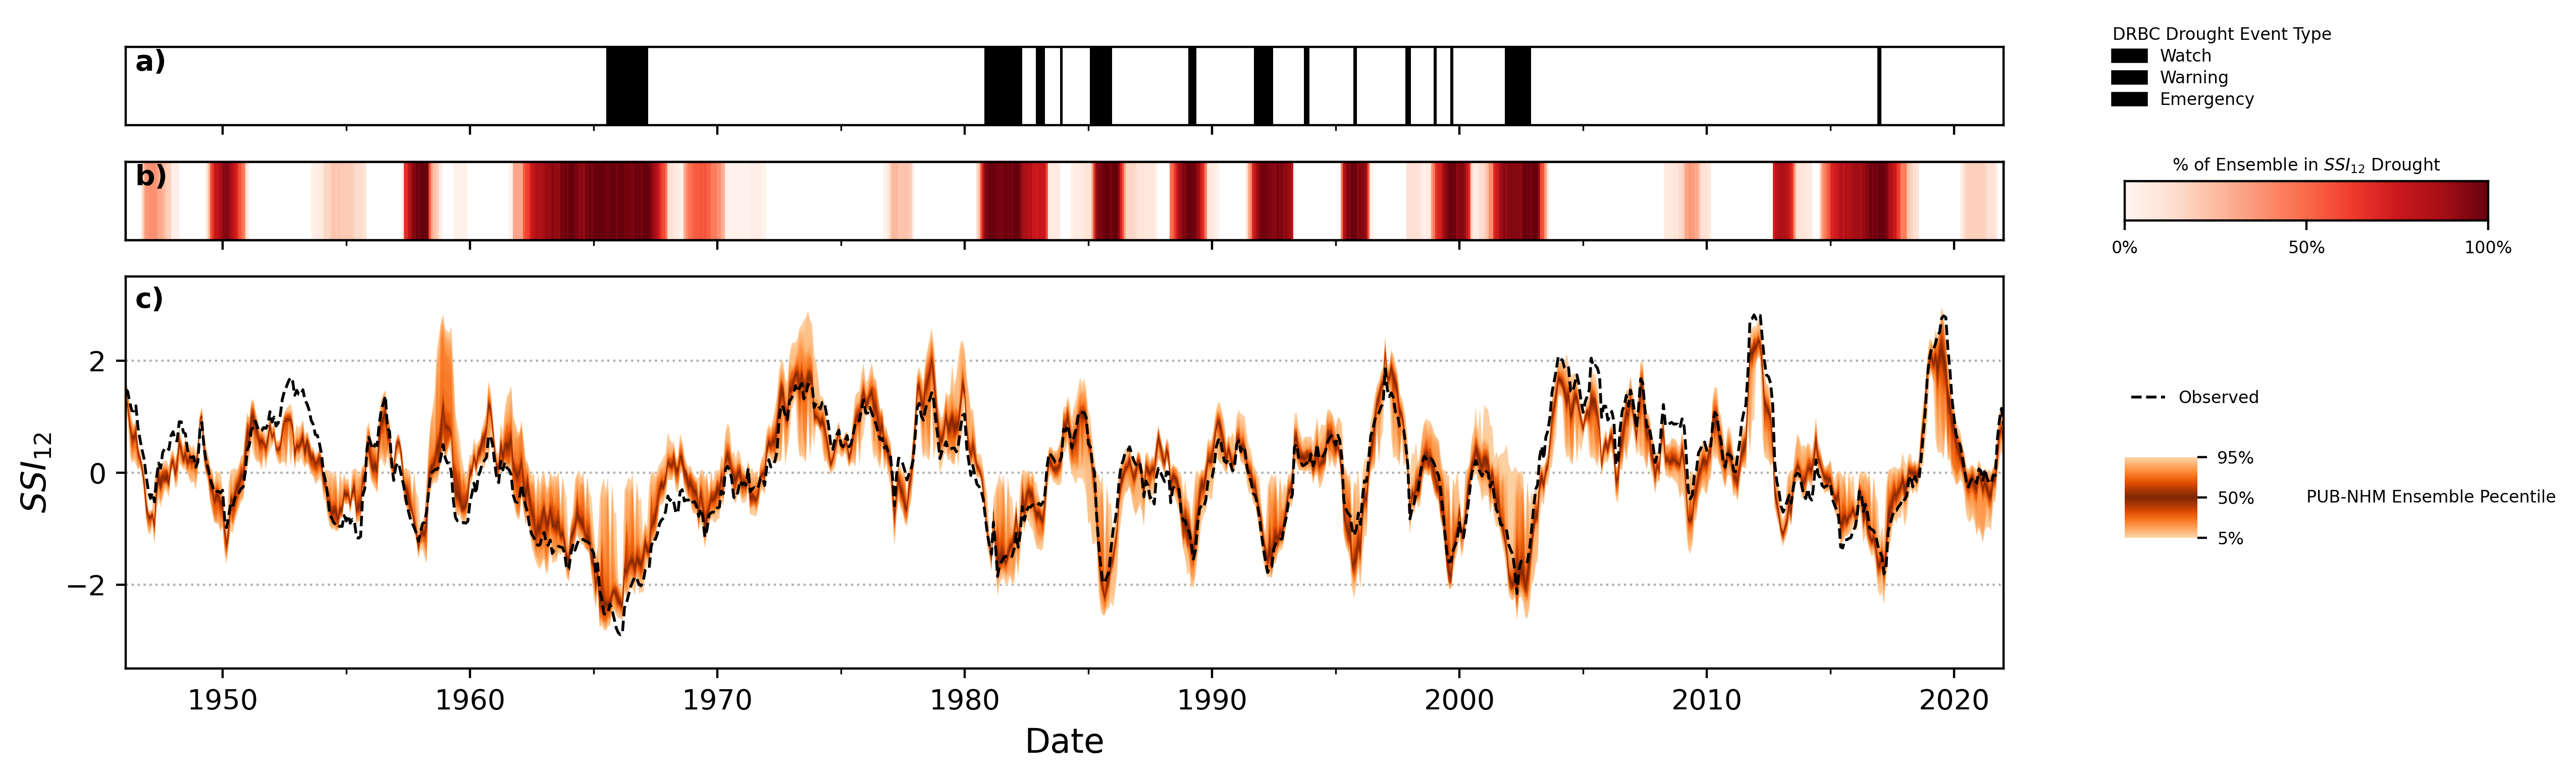

In [8]:
import matplotlib.dates as mdates

axis_label_fsize = 12
legend_fsize = 6


def add_cbar_to_ax(cbar_ax, 
                   model, 
                   ticks, ticklabels,
                   mirrored_cmap = True,
                   cmap=None, 
                   fontsize=10,
                   orientation='vertical'):
        """
        Uses the 
        """
        norm = Normalize(vmin=-0.15, vmax=1.15)
        
        if mirrored_cmap:
            ensemble_cmap = create_mirrored_cmap('Oranges') if 'nhm' in model else create_mirrored_cmap('Blues')
        else:
            ensemble_cmap = cmap if cmap is not None else plt.cm.get_cmap('Oranges')
        ensemble_cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=ensemble_cmap, norm=norm),
                            cax=cbar_ax, 
                            orientation=orientation)
        ensemble_cbar.set_label('Ensemble Percentile', labelpad=5)
        # Put label on top of cbar
        ensemble_cbar.set_ticks(ticks)  # Set ticks if you want specific ones
        ensemble_cbar.set_ticklabels(ticklabels)  
        ensemble_cbar.ax.tick_params(labelsize=fontsize)
        ensemble_cbar.ax.xaxis.set_ticks_position('bottom')
        ensemble_cbar.ax.xaxis.set_label_position('top')
        ensemble_cbar.ax.yaxis.set_label_position('left')
        ensemble_cbar.set_label('')

        # Add a label to the top of the colorbar
        ensemble_cbar.ax.text(2.5, 0.5, f'{model_labels[model]} Pecentile', 
                              transform=ensemble_cbar.ax.transAxes, 
                              ha='left', va='center', fontsize=fontsize)
        ensemble_cbar.ax.xaxis.label.set_size(fontsize)
        ensemble_cbar.ax.set_ylim([0, 1.0])
        ensemble_cbar.ax.xaxis.set_visible(False)
        for s in ['top', 'bottom', 'left', 'right']:
            cbar_ax.spines[s].set_visible(False)
        ensemble_cbar.outline.set_visible(False)
        return cbar_ax


def plot_drbc_droughts_and_ssi(ssi, models, node, 
                               start_date, end_date,
                               percentiles_cmap = True, 
                               q_lower_bound = 0.05, q_upper_bound = 0.95,
                               plot_observed=False,
                               fig_dir = fig_dir):
    
    ### SSI-based droughts
    for m in models:
        assert(m in ssi.keys()), f"Model {m} not in ssi results dict"
    # Define colors for different event types
    event_colors = {'Watch': 'black', 
                    'Warning': 'black', 
                    'Emergency': 'black'}

    subplot_labels = ['a)','b)','c)']
    
    
    use_model_xs = models[0] if 'ensemble' not in models[0] else models[0].split('_ensemble')[0]
    xs = ssi[use_model_xs].loc[start_date:end_date, node].index

    # Create a figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 4), dpi=400,
                                sharex=True, 
                                gridspec_kw={'height_ratios': [1, 1, 5]})

    ### SUBPLOT 1:  DRBC drought events
    subplot_drbc_drought_events(ax=ax1, 
                                start_date=start_date, end_date=end_date,
                                event_colors=event_colors)

    ### SUBPLOT 2: heatmap of fraction of ensemble in drought for every day
    ensemble_models = [m for m in models if 'ensemble' in m]
    grid = np.zeros((len(ensemble_models), len(xs)))
    
    for i, model in enumerate(ensemble_models):
        grid[i, :] = get_fraction_of_ensemble_in_drought(ssi[model], node, start_date, end_date)

    # Find ax2 location lower bound
    ax2_lower_bound = ax2.get_position().bounds[1]
    ax2_height = ax2.get_position().bounds[3]
    
    # Make new ax off to right side to place colorbar in
    cbar_ax = fig.add_axes([0.95, ax2_lower_bound + (ax2_height)/4, 
                            0.15, ax2_height/2])
    use_cmap = modify_cmap_zero_to_white('Reds')
    
    
    ax2b = ax2.twiny()
    ax2b.xaxis.set_ticks_position('bottom')

    sns.heatmap(grid*100, ax=ax2b, cmap=use_cmap, 
                vmin=0, vmax=100, 
                cbar=True, cbar_ax=cbar_ax, 
                cbar_kws={'label': '% of Ensemble' r' in $SSI_{12}$ Drought',
                          'orientation': 'horizontal'})
    ax2b.set_xlim(0, len(grid[0, :]))
    cbar = ax2b.collections[0].colorbar
    cbar.set_ticks([0, 50, 100])
    cbar.set_ticklabels(["0%", "50%", "100%"])
    cbar.ax.tick_params(labelsize=legend_fsize)
    cbar.ax.xaxis.set_ticks_position('bottom')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.xaxis.label.set_size(legend_fsize)
    cbar.outline.set_visible(True)
    

    ax2b.set_xticks([])
    ax2b.set_xticklabels([])
    ax2b.set_yticks([])
    ax2b.set_yticklabels([])
    ax2b.patch.set_visible(False)
            
    # Add box around subplot
    for s in ['top', 'bottom', 'left', 'right']:
        ax2b.spines[s].set_visible(True)    
        cbar.ax.spines[s].set_visible(True)
    
    ## Subplot 2: SSI values
    
    for m in models:
        if 'ensemble' in m:                 
            realizations = list(ssi[m].keys())
            for i, real_i in enumerate(realizations):
                ssi_instance = ssi_d[m][real_i].loc[:, node]

                if i == 0:
                    ensemble_data = pd.DataFrame(ssi_instance, columns=[i], 
                                                index=ssi_instance.index)
                else:
                    ensemble_data[i] = ssi_instance
                
                ensemble_data = ensemble_data.dropna(axis=1)
                    
            # Full period
            if percentiles_cmap:
                plot_ensemble_percentile_cmap(ensemble_data, m,
                                            ax3, q_lower_bound, q_upper_bound, 
                                            alpha=1, zorder=2)
            else:        
                ax3.fill_between(x=ensemble_data.index,
                        y1=ensemble_data.quantile(q_lower_bound, axis=1),
                        y2=ensemble_data.quantile(q_upper_bound, axis=1),
                        color=model_colors[m], 
                        zorder=3,
                        alpha=0.8, 
                        interpolate=False, 
                        label = model_labels[m])

        else:
            ssi_instance = ssi[m].loc[:, node]
            ax3.plot(ssi_instance,
                    c=model_colors[m], 
                    label = model_labels[m],
                    lw=1, zorder = 6)

    if plot_observed:
        
        model_ls = '--'
        ssi_instance = ssi['obs'].loc[:, node]
        ax3.plot(ssi_instance,
                c=model_colors['obs'], 
                label = f'{model_labels["obs"]}',
                ls=model_ls,
                lw=1, zorder = 10)

    use_xlim = ssi[use_model_xs].loc[start_date:end_date, node].index
    ax1.set_xlim(use_xlim[0], use_xlim[-1])
    ax3.set_xlim(use_xlim[0], use_xlim[-1])
    ax1.set_xticklabels([])
    # ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax3.set_ylim([-3.5,3.5])
    
    ax3.grid(axis='y', zorder=0, color='k', alpha=0.3, ls=':')
    ax3.xaxis.set_minor_locator(mdates.YearLocator(5))
    ax3.xaxis.set_major_locator(mdates.YearLocator(10))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Subplot labels
    subplot_label_fsize = 10
    ax1.annotate(subplot_labels[0], xy=(0.005, 0.975), 
                 xycoords='axes fraction', 
                 ha='left', va='top', weight='bold',
                 fontsize=subplot_label_fsize)
    ax2b.annotate(subplot_labels[1], xy=(0.005, 0.975), 
                 xycoords='axes fraction', 
                 ha='left', va='top', weight='bold',
                 fontsize=subplot_label_fsize)
    ax3.annotate(subplot_labels[2], xy=(0.005, 0.975), 
                 xycoords='axes fraction', 
                 ha='left', va='top', weight='bold',
                 fontsize=subplot_label_fsize)
    
    
    ax3.set_ylabel(r'$SSI_{12}$', fontsize=axis_label_fsize)
    ax3.set_xlabel('Date', fontsize=axis_label_fsize)
    
    # Make a cbar for the ensemble percentiles
    if percentiles_cmap:
        cbar_ax = fig.add_axes([0.95, ax3.get_position().bounds[1] + (ax3.get_position().bounds[3])/3, 
                                0.03, 0.1])
        cbar_ax = add_cbar_to_ax(cbar_ax,
                          models[0], 
                          ticks=[0, 0.5, 1], 
                          ticklabels=['5%', '50%', '95%'],
                          mirrored_cmap = True,
                          fontsize=legend_fsize,
                          orientation='vertical')
    
    ax3.legend(loc='upper left', bbox_to_anchor=(1.06, 0.75), fontsize=legend_fsize, frameon=False)
    
    # Make a legend for ax1 (DRBC drought events)
    handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
    ax1.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.45), 
            ncols= 1, labelspacing=0.3, frameon = False,
               title='DRBC Drought Event Type', title_fontsize=legend_fsize, fontsize=legend_fsize, alignment='left')

    fig.align_ylabels()
    fname = f'{models[0]}_full_ssi_{node}'
    plt.savefig(f'{fig_dir}/svg/{fname}.svg', dpi = 200, bbox_inches='tight')
    plt.savefig(f'{fig_dir}/droughts/{fname}.png', dpi = 200, bbox_inches='tight')

    plt.show()
    return 

plot_drbc_droughts_and_ssi(ssi_d, 
                           ['obs_pub_nhmv10_ObsScaled_ensemble'], 
                           'delTrenton', 
                           '1945-01-01', '2022-12-31',
                           plot_observed=True,
                           percentiles_cmap=True)



(28477, 49)


C:\Users\tjame\AppData\Local\Temp\ipykernel_4828\275780937.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap(cmap_name)


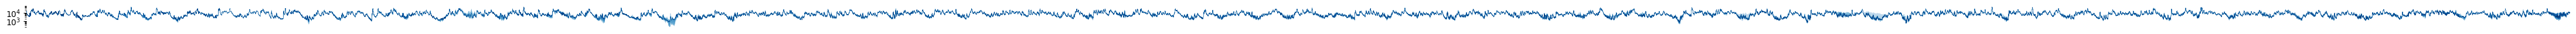

In [7]:
def plot_ensemble_timeseries_aesthetic(Q, models, node, 
                                       model_colors=model_colors, logscale=False,
                                       fig_dir=fig_dir, 
                                       smoothing_window=1,
                                       facecolor = 'dimgrey'):
    fig, ax = plt.subplots(figsize=(56, 0.5))
    
    # Customize the axis
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')

    for spine in ax.spines.values():  # Remove all spines
        spine.set_visible(False)
    # Set background to grey
    ax.set_facecolor(facecolor)
    
    for model in models:
    
        if 'ensemble' in model:
            realizations = list(Q[model].keys())
            for i, real_i in enumerate(realizations):
                Q_i = Q[model][real_i].loc[:, node]

                if i == 0:
                    ensemble_data = pd.DataFrame(Q_i, columns=[i], 
                                                index=Q_i.index)
                else:
                    ensemble_data[i] = Q_i
                
            ensemble_data = ensemble_data.rolling(smoothing_window).mean()
            ensemble_data = ensemble_data.iloc[smoothing_window-1:-smoothing_window+1]
            
            ensemble_data = ensemble_data.dropna(axis=1)
            print(ensemble_data.shape)
                
            ax = plot_ensemble_percentile_cmap(ensemble_data, model, ax, 0.95, 0.05, alpha=1, zorder=1)
            ax.set_xlim(ensemble_data.index[0], ensemble_data.index[-1])
        else:
            Q_mod = Q[model][node].rolling(smoothing_window).mean()
            Q_mod= Q_mod.iloc[smoothing_window-1:-smoothing_window+1]
            Q_mod = Q_mod.dropna(axis=1)
            ax.plot(Q_mod.index, Q_mod, color=model_colors[model], 
                    lw=1.5, label=model_labels[model], 
                    zorder=2)
            ax.set_xlim(Q_mod.index[0], Q_mod.index[-1])
    
    # ax.set_ylim(0, ymax)
    if logscale:
        ax.set_yscale('log')
            
    # fig.tight_layout()
    # plt.savefig(f'{fig_dir}/superlong_ensemble_timeseries_{node}.svg', dpi = 500,  bbox_inches='tight', pad_inches=0)
    fig_dpi = 750
    plt.savefig(f'{fig_dir}/superlong_ensemble_timeseries_{node}_dpi{fig_dpi}_smooth{smoothing_window}.png', 
                dpi=fig_dpi, bbox_inches='tight', pad_inches=0)
    
    return 

plot_ensemble_timeseries_aesthetic(Q, ['obs_pub_nwmv21_ObsScaled_ensemble'], 'delTrenton', 
                                   logscale=True, facecolor='w', smoothing_window=7)

In [ ]:

## New figure: Plot flow for 1 year of interest compared to 
## Weekly flow distributions acorss the year using a colormap
## Highlighting a single trace for a specific year


def plot_flow_distribution_with_highlight(Q, model,
                                          node,
                                          highlight_years,
                                          aggregation_length='W', 
                                          ax=None):
    """
    Plot flow distribution for a single node
    """
    data = Q[model].copy()
    ## Aggregate dat
    data['TotalNYC'] = data[nyc_reservoirs].sum(axis=1)
    data = data.resample('W').sum()
    data.dropna(inplace=True)
    
    # Add column for week of year
    data['week'] = data.index.isocalendar().week
    
    # Calculate the percentiles - 5th, 25th, 50th, 75th, and 95th for the whole period
    percentiles = np.arange(0.0, 100, 5)
    if percentiles[-1] != 100:
        percentiles = np.append(percentiles, 100)
        
    perc_data = data.groupby('week')[node].quantile(np.array(percentiles)/100.0)
    
    if ax is None:
        add_colorbar = True
        fig, ax = plt.subplots(figsize=(10, 2))
        is_subplot = False
    else:
        add_colorbar = False
        is_subplot = True
        
    # Plot percentiles using colormap
    norm = Normalize(vmin=0, vmax=100)  # Assuming your percentiles range from 0 to 100
    sm = ScalarMappable(cmap=plt.cm.plasma_r, norm=norm)
    sm.set_array([])  # Set an empty array to initialize the ScalarMappable

    # Plot percentiles using colormap
    colors = plt.cm.plasma_r(np.linspace(0, 1, len(percentiles)-1))
    for i in range(len(percentiles)-1):
        p_lower = percentiles[i]/100.0
        p_upper = percentiles[i+1]/100.0
        lower = perc_data.loc[1:, p_lower]
        upper = perc_data.loc[1:, p_upper]    
        lower_values = np.nan_to_num(lower.values, nan=np.nanmean(lower.values))
        upper_values = np.nan_to_num(upper.values, nan=np.nanmean(upper.values))
        lower_values = lower_values[:-1]
        upper_values = upper_values[:-1]
        xs = np.arange(1, len(lower_values)+1)
        ax.fill_between(xs, lower_values, upper_values, 
                        color=colors[i], alpha=1, 
                        edgecolor='none', linewidth=0.0)
    
    
    # Highlight the specific year with a black line
    for yr in highlight_years:
        # Extract the data for the year of interest
        year_data = data[node][data.index.year == yr]
        
        year_values = year_data.values
        xs = np.arange(1, len(year_values)+1)
        ax.plot(xs, year_values, 
                color='k', linewidth=2,
                ls='--')
        
    # Add colorbar to the right side of the plot
    if add_colorbar:
        cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=10)
        cbar.set_label('Streamflow Percentile', rotation=270, labelpad=12)
        cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Set ticks if you want specific ones


    # Get current xticks on axis
    xticks = ax.get_xticks()
    
    # Set xticks every 12 weeks
    ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
    
    # Multiple ticks by 7 and set as xtick labels
    xticks = xticks*7
    
    # Convert day or year to month
    xticks = pd.to_datetime(xticks, unit='D')
    xticks = xticks.month_name().str.slice(stop=3)
    ax.set_xticklabels(xticks)
    ax.set_ylabel('Streamflow (MGD)', fontsize=12)
    ax.set_xlabel('Month', fontsize = 12)
    
    ax.set_yscale('log')
    return


fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for i, node in enumerate(['TotalNYC', 'delMontague', 'delTrenton']):
    ax = axs[i]
    plot_flow_distribution_with_highlight(Q, 'obs_pub_nwmv21_ObsScaled', 
                                      node, [1964], 
                                      aggregation_length='W', 
                                      ax=ax)

plt.show()    


plot_flow_distribution_with_highlight(Q, 'obs_pub_nwmv21_ObsScaled', 
                                    'TotalNYC', [1964], 
                                    aggregation_length='W', 
                                    ax=None)

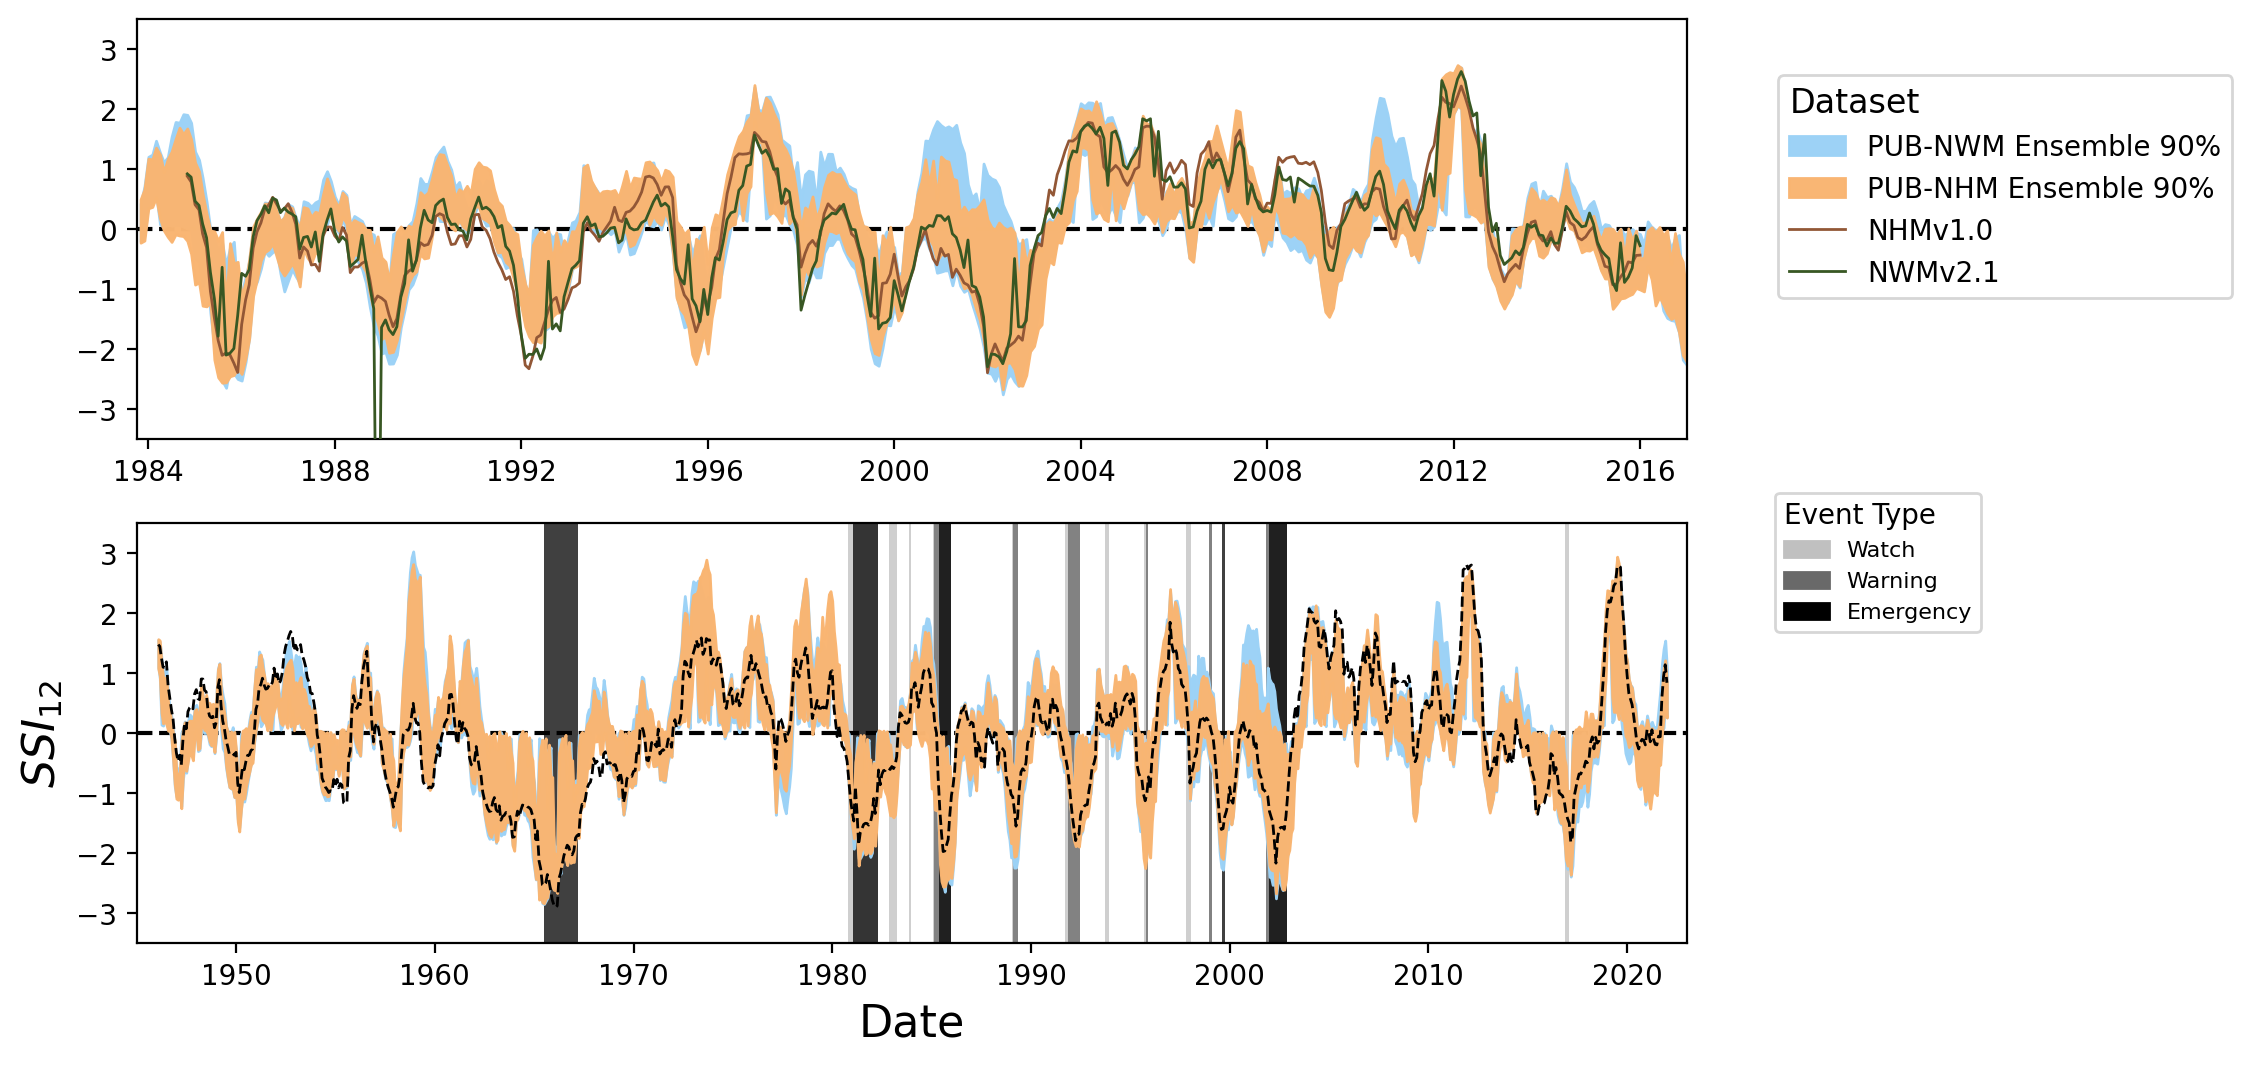

In [278]:
def plot_two_panel_ssi():
        # Specifications
    t_start='1983-10-01'
    t_end='2016-12-31'
    plot_nodes = ['delTrenton']
    transform_type = 'rolling'
    # transform_type = 'aggregation'
    window = 365
    aggregation_type = 'mean'
    aggregation_length = 'M' #'M'

    # Vertical lines at model start and end dates
    mod_ls = '--'
    mod_z = 0
    mod_lw=2
    mod_a =0.8
    mod_end_date = pd.to_datetime('2016-12-31') # if (m == 'nhmv10') else pd.to_datetime('2020-12-31')

    ### SSI-based droughts
    ssi_model_types = ['nhmv10', 'nwmv21', 
                    'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']

    # Define colors for different event types
    event_colors = {'Watch': 'silver', 
                    'Warning': 'dimgrey', 
                    'Emergency': 'black'}

    ax3_ymin = -3.15
    ax3_ymax = 3.15

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), dpi=200,
                                sharex=False, gridspec_kw={'height_ratios': [1,1]})

    ### SUBPLOT 1:  All models for overlap period (1983-10-01 to 2016-12-31)

    ### SUBPLOT 2: Just ob_pub ensemble for full period (1945-01-01 to 2022-12-31)
    band_ymax=3.5 
    band_ymin = 3.0
    ax1.hlines(y=0, xmin=pd.to_datetime('1983-10-01'), xmax=pd.to_datetime('2016-12-31'),
        color='k', lw=1.5, ls='--', zorder=0)
    
    for m in ['obs_pub_nwmv21_ObsScaled_ensemble', 'obs_pub_nhmv10_ObsScaled_ensemble']:                 
        for i, real_i in enumerate(ssi_d[m].keys()):
            ssi_instance = ssi_d[m][real_i].loc[:, plot_nodes[0]]
            Q_instance = Q[m][real_i].loc[:, plot_nodes[0]]

            
            if i == 0:
                ensemble_data = pd.DataFrame(ssi_instance, columns=[i], 
                                            index=ssi_instance.index)
            else:
                ensemble_data[i] = ssi_instance
            
            ensemble_data = ensemble_data.dropna(axis=1)
        

        #     plot_ssi_band(ssi_instance, 
        #         band_ymax, band_ymin, ax=ax2, 
        #         fill_color='maroon',
        #         alpha = 0.07)
        
        # Full period
        # Plot flow 90 quantile
        ax2.fill_between(x=ensemble_data.index,
                y1=ensemble_data.quantile(0.95, axis=1),
                y2=ensemble_data.quantile(0.05, axis=1),
                color=model_colors[m], 
                zorder=3,
                alpha=0.99, 
                interpolate=False)

        # Overlap period in ax1
        ensemble_data = ensemble_data.loc[t_start:t_end]
        ax1.fill_between(x=ensemble_data.index,
                y1=ensemble_data.quantile(0.95, axis=1),
                y2=ensemble_data.quantile(0.05, axis=1),
                color=model_colors[m], 
                edgecolor=model_colors[m],
                alpha=.99, 
                interpolate=False, 
                label = f'{model_labels[m]} 90%', zorder=2)


    for m in ['obs']: # ['obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled']:
        model_ls = '--' if m == 'obs' else '-'
        ssi_instance = ssi_d[m].loc[:, plot_nodes[0]]
        ax2.plot(ssi_instance,
                c=model_colors[m], label = model_labels[m],
                ls=model_ls,
                lw=1, zorder = 5)

    for m in ['nhmv10', 'nwmv21']: #, 'obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled']:
        model_ls = '--' if m == 'obs' else '-'
        ssi_instance = ssi_d[m].loc[t_start:t_end, plot_nodes[0]]
        ax1.plot(ssi_instance,
                c=model_colors[m], label = model_labels[m],
                ls=model_ls,
                lw=1, zorder = 5)
        
    for index, row in drbc_droughts.iterrows():
        color = event_colors[row['event_type']]
        start_date = pd.to_datetime(row['start_date'])
        end_date = pd.to_datetime(row['end_date'])
        ax2.axvspan(start_date, end_date,
                    ymin=0, ymax=1, 
                    facecolor=color, 
                    edgecolor='none', alpha=0.75, zorder=0)

    # Adding legend for the event types
    handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
    ax2.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1), 
            title='Event Type', title_fontsize=10, fontsize=8, alignment='left')
    
    # Horizontal line at ssi 0
    ax2.hlines(y=0, 
               xmin=pd.to_datetime('1945-01-01'), xmax=pd.to_datetime('2022-12-31'),
               color='k', lw=1.5, ls='--', 
               zorder=1)

        
    ax1.set_xlim(pd.to_datetime(t_start), pd.to_datetime(t_end))
    ax2.set_xlim(pd.to_datetime('1945-01-01'), pd.to_datetime('2022-12-31'))
    ax1.set_ylim([-3.5,3.5])
    ax2.set_ylim([-3.5,3.5])
    ax2.set_ylabel(r'$SSI_{12}$', fontsize=16)
    ax2.grid(True, axis='y', which = 'minor', zorder=1)
    ax2.set_xlabel('Date', fontsize=16)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 0.90), 
            title='Dataset', title_fontsize=12, fontsize=10, alignment='left')
    
    fig.align_ylabels()
    plt.show()
    return 

plot_two_panel_ssi()


In [27]:
# Modify basin geometries to not overlap
# update names to match pywr nodes
g1 = node_geoms
nodes = g1['node'].values
for i in range(len(nodes)):
    if nodes[i].split('_')[0]=='link':
        nodes[i] = nodes[i].split('_')[1]
g1['node'] = nodes

### subtract upstream catchments from mainstem nodes - note on a few occasions (eg pepacton & its gage), they are too close together and dont recognise a difference,so they disappear from this dataframe.
for node, upstreams in upstream_nodes_dict.items():
    for upstream in upstreams:
        overlay = g1.loc[g1['node'] == node].overlay(g1.loc[g1['node'] == upstream], how='difference')
        g1 = g1.loc[g1['node'] != node]
        g1 = pd.concat([g1, overlay])

g1.reset_index(inplace=True, drop=True)
g1['idx'] = list(g1.index)



c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 37 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,node,lat,long,comid,geometry,idx
0,cannonsville,42.065872,-75.37462,2614136,"POLYGON ((-75.25965 42.07860, -75.25913 42.075...",0


In [12]:
def plot_ssi_band(ssi, ymax, ymin, ax = None, 
                  fill_color = 'grey',
                  alpha = 0.75):
    """Plot the standardized index values as a time series. 
    Modified from https://github.com/martinvonk/SPEI/blob/main/src/spei/plot.py

    Parameters
    ----------
    si : pandas.Series
        Series of the standardized index
    bound : int, optional
        Maximum and minimum ylim of plot
    figsize : tuple, optional
        Figure size, by default (8, 4)
    ax : matplotlib.Axes, optional
        Axes handle, by default None which create a new axes

    Returns
    -------
    matplotlib.Axes
        Axes handle
    """

    # Classify droughts
    in_critical_drought = False
    droughts = np.zeros_like(ssi.values)
    drought_days = []
    for ind in range(len(droughts)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
            
        else:
            if in_critical_drought:
                droughts[drought_days] =1
            in_critical_drought = False
            drought_days = [] 
    
    # Handle edge case
    if in_critical_drought:
        droughts[drought_days] =1
        
        
    ax.fill_between(x=ssi.index, y1=ymax, y2=ymin, 
                    where=(droughts>0), color=fill_color, alpha=alpha, 
                    zorder=2,
                    interpolate=False)
    return ax



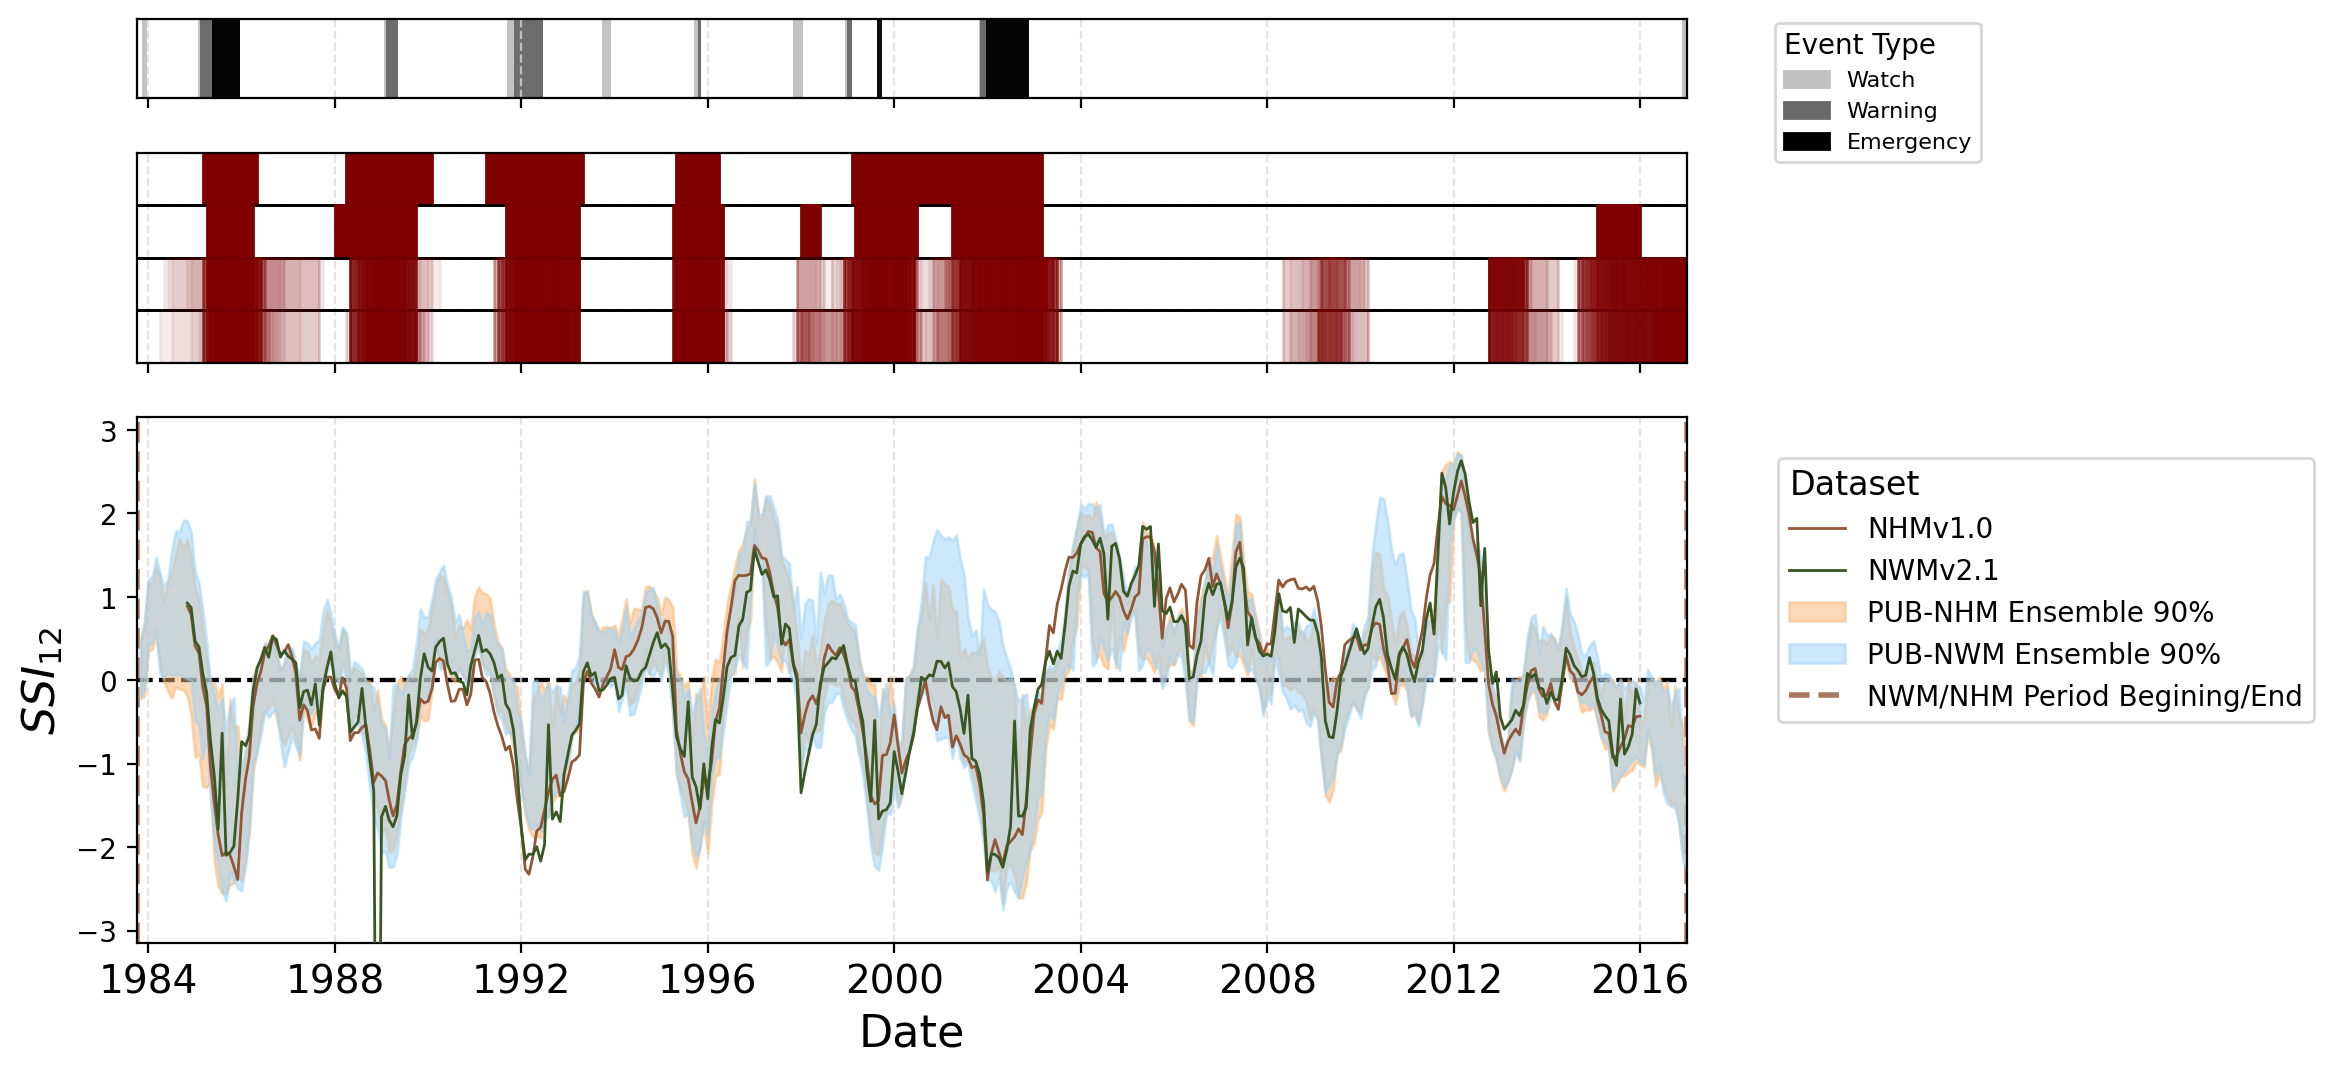

In [28]:
# Specifications
t_start='1983-10-01'
t_end='2016-12-31'
plot_nodes = ['delTrenton']
transform_type = 'rolling'
# transform_type = 'aggregation'
window = 365
aggregation_type = 'mean'
aggregation_length = 'M' #'M'

# Define colors for different event types
event_colors = {'Watch': 'silver', 
                'Warning': 'dimgrey', 
                'Emergency': 'black'}

ax3_ymin = -3.15
ax3_ymax = 3.15

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), dpi=200,
                               sharex=True, gridspec_kw={'height_ratios': [0.75, 2,5]})

## DRBC-classified drought events
# Iterate through the events and create colored bars
for index, row in drbc_droughts.iterrows():
    color = event_colors[row['event_type']]
    start_date = pd.to_datetime(row['start_date'])
    end_date = pd.to_datetime(row['end_date'])
    ax1.axvspan(start_date, end_date, facecolor=color, edgecolor='none', alpha=0.95)

# Adding legend for the event types
handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
ax1.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1), 
           title='Event Type', title_fontsize=10, fontsize=8, alignment='left')
# ax1.set_ylabel('DRBC\nDroughts', fontsize=14)
ax1.set_yticks([])

### SSI-based droughts
ssi_model_types = ['nhmv10', 'nwmv21', 
                   'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']
for i, m in enumerate(ssi_model_types):
    band_ymax= 1 - i / len(ssi_model_types)
    band_ymin = band_ymax - 1 / len(ssi_model_types)
    band_xmin = pd.to_datetime(t_start) if ('obs_pub' in m) else pd.to_datetime('1983-10-01')
    band_xmax = pd.to_datetime(t_end) if ('obs_pub' in m) else pd.to_datetime('2016-12-30')
    

    ax2.hlines(y=band_ymin, xmin=band_xmin, xmax=band_xmax,
                color='k', lw=1)
    if i > 0:
        ax2.hlines(y=band_ymax, xmin=pd.to_datetime(t_start), xmax=pd.to_datetime(t_end),
                lw=1, ls='--', color='k', zorder=0)
        ax2.hlines(y=band_ymax, xmin=band_xmin, xmax=band_xmax,
                color='k', lw=1)
    
    # ax2.vlines(x=band_xmin, ymin=band_ymin, ymax=band_ymax, lw=1.5, color='k')
    # ax2.vlines(x=band_xmax, ymin=band_ymin, ymax=band_ymax, lw=1.5, color='k')
    
    
    if 'ensemble' in m:
        
        
        for i, real_i in enumerate(ssi_d[m].keys()):
            ssi_instance = ssi_d[m][real_i].loc[t_start:t_end, plot_nodes[0]]
            Q_instance = Q[m][real_i].loc[ssi_instance.index, plot_nodes[0]]
            
            plot_ssi_band(ssi_instance, 
                          band_ymax, band_ymin, ax=ax2, 
                          fill_color='maroon',
                          alpha = 0.07)
            
            if i == 0:
                ensemble_data = pd.DataFrame(ssi_instance, columns=[i], 
                                            index=ssi_instance.index)
            else:
                ensemble_data[i] = ssi_instance
            
            ensemble_data = ensemble_data.dropna(axis=1)
        
        # ensemble_data = transform_flow(ensemble_data, transform = transform_type,
        #                                window=window, aggregation_type = aggregation_type,
        #                                aggregation_length = aggregation_length)       
            
        # Plot flow 90 quantile
        ax3.fill_between(x=ensemble_data.index,
                        y1=ensemble_data.quantile(0.95, axis=1),
                        y2=ensemble_data.quantile(0.05, axis=1),
                        color=model_colors[m], alpha=0.5, 
                        interpolate=False, 
                        label = f'{model_labels[m]} 90%', zorder=2)
        

    else:
        if m in ['nhmv10', 'nwmv21']:
            plot_ssi_band(ssi_d[m].loc[t_start:t_end, plot_nodes[0]], 
                        band_ymax, band_ymin, ax=ax2, alpha =1,
                        fill_color = 'maroon')

        ## Plot ssi

        ax3.plot(ssi_d[m].loc[t_start:t_end, plot_nodes[0]],
                 c=model_colors[m], label = model_labels[m],
                 lw=1, zorder = 5)
  
  
        # Horizontal line at ssi 0
        ax3.hlines(y=0, xmin=pd.to_datetime(t_start), xmax=pd.to_datetime(t_end),
                    color='k', lw=1.5, ls='--', zorder=0)



# Vertical lines at model start and end dates
mod_ls = '--'
mod_z = 0
mod_lw=2
mod_a =0.8
mod_end_date = pd.to_datetime('2016-12-31') # if (m == 'nhmv10') else pd.to_datetime('2020-12-31')

# ax2.vlines(x=pd.to_datetime('1983-10-01'), ymin=0.5, ymax=1,
#         lw=mod_lw, color=model_colors['nhmv10'], zorder= mod_z,
#         ls=mod_ls, alpha=mod_a)
# ax2.vlines(x=mod_end_date, ymin=0.5, ymax=1,
#         lw=mod_lw, color=model_colors['nhmv10'], zorder=mod_z, 
#         ls=mod_ls, alpha=mod_a)

    
ax3.vlines(x=pd.to_datetime('1983-10-01'), ymin=ax3_ymin, ymax=ax3_ymax, 
        lw=mod_lw, color=model_colors['nhmv10'], zorder= mod_z,
        ls=mod_ls, alpha=mod_a)


ax3.vlines(x=mod_end_date, ymin=ax3_ymin, ymax=ax3_ymax, 
        lw=mod_lw, color=model_colors['nhmv10'], zorder=mod_z, 
        ls=mod_ls,
        label=f'NWM/NHM Period Begining/End', alpha=mod_a)



# ax3.set_yscale('log')
ax2.set_ylim([0,1])
ax2.set_yticklabels([])
ax2.set_yticks([])


ax3.set_ylim([ax3_ymin, ax3_ymax])
ax3.set_ylabel(r'$SSI_{12}$', fontsize=16)
ax3.grid(True, axis='y', which = 'minor', zorder=1)

ax1.grid(True, axis='x', which = 'major', zorder=0, ls='--', color='gainsboro', alpha=0.75)
ax2.grid(True, axis='x', which = 'major', zorder=0, ls='--', color='gainsboro', alpha=0.75)
ax3.grid(True, axis='x', which = 'major', zorder=0, ls='--', color='gainsboro', alpha=0.75)

ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 0.95), 
           title='Dataset', title_fontsize=12, fontsize=10, alignment='left')
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize=14)
plt.xlim(pd.to_datetime(t_start), pd.to_datetime(t_end))
# plt.ylabel(f'SSI-{int(window/29)}', fontsize=14)
fig.align_ylabels()
# ax2.legend()
plt.show()


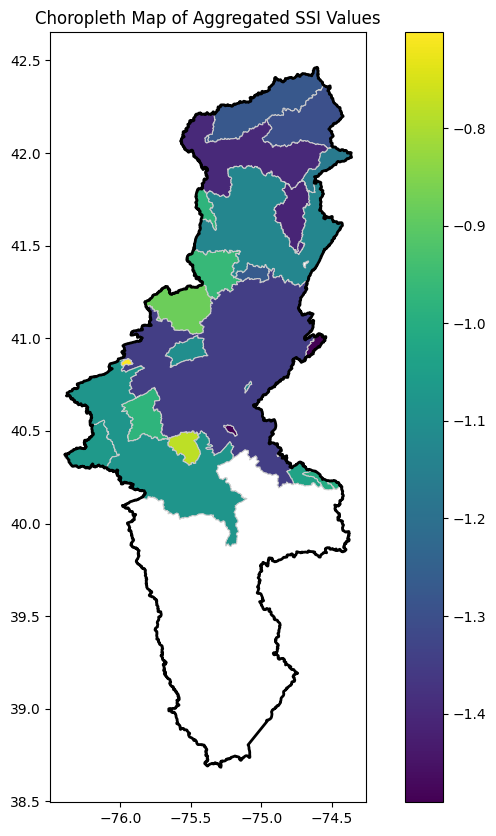

In [32]:
def plot_choropleth(node_basins, ssi, 
                    time_range=('1960-01-01', '2010-12-31'),
                    drb_boundary = None,
                    aggregation_method='mean'):
    aggregation_method_options = ['mean', 'min']
    
    # Aggregate the SSI values over the given time range
    ssi = ssi.loc[time_range[0]:time_range[1],:]
    if aggregation_method == 'mean':
        agg_ssi = ssi.mean().reset_index()
    elif aggregation_method == 'min':
        agg_ssi = ssi.min().reset_index()
    agg_ssi.columns = ['node', 'ssi']
    
    # Prepare a DataFrame for merging with node_basins
    merged = node_basins.merge(agg_ssi, on ='node')
    
    # Create the Choropleth figure
    fig, ax = plt.subplots(figsize=(10, 10))
    merged.plot(column='ssi', cmap='viridis', # vmax=0, vmin=-2, 
                linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    if drb_boundary is not None:
        drb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

    plt.title('Choropleth Map of Aggregated SSI Values')
    plt.show()
    
    return

plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1985-02-22',	'1986-04-26'))

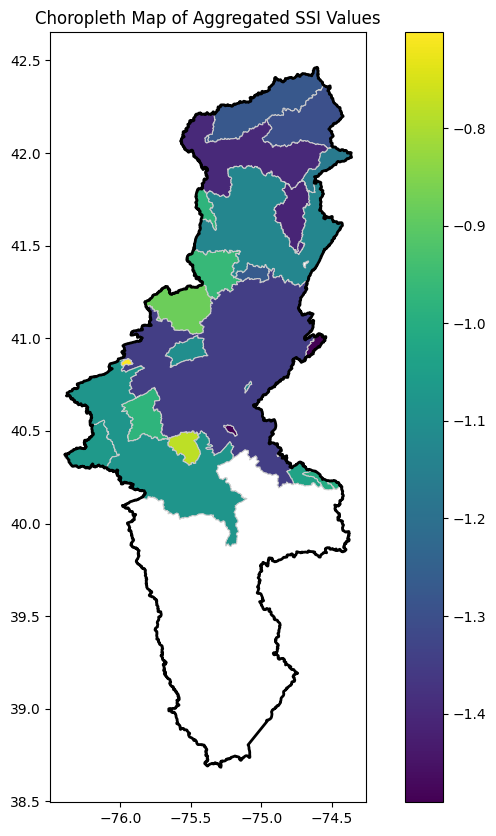

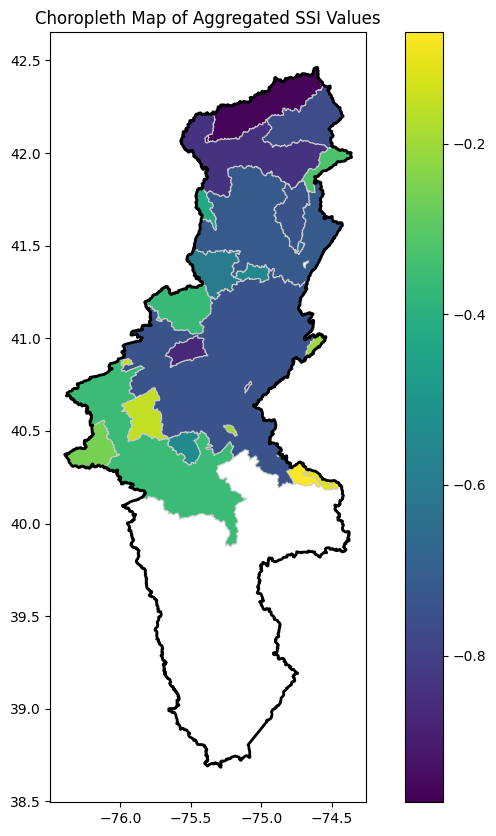

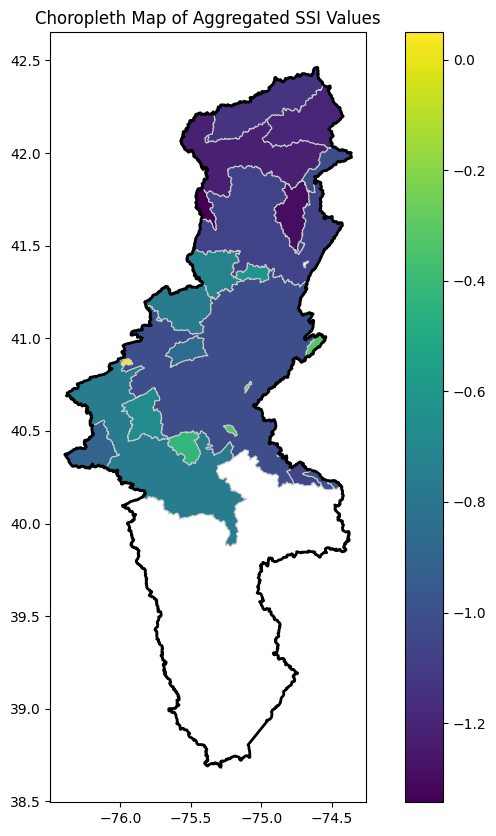

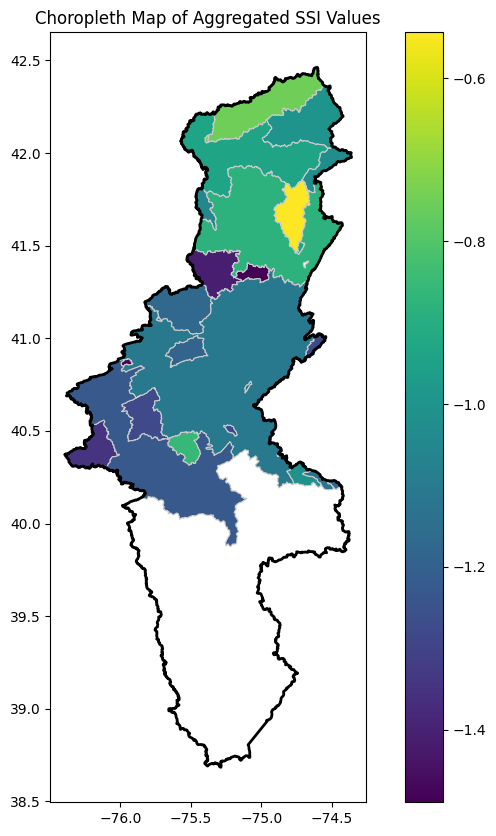

In [34]:
drought_metrics.loc[drought_metrics['node']=='delTrenton']


plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1985-02-22',	'1986-04-26'))

plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1988-03-01',	'1990-02-07'))
plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1995-04-14',	'1996-04-18'))
plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('2000-09-17', '2003-03-24'))

In [1]:
ssi_d

NameError: name 'ssi_d' is not defined

In [31]:
ssi_d['nhmv10']

,delTrenton
datetime,
1984-10-31,0.887851
1984-11-30,0.792328
1984-12-31,0.412629
1985-01-31,0.326280
1985-02-28,-0.071212
...,...
2015-08-31,-0.703354
2015-09-30,-0.540738
2015-10-31,-0.557081


In [38]:
plot_nodes = ['Total NYC', 'blueMarsh', 'beltzvilleCombined']
plot_nodes = nyc_reservoirs
plot_nodes= ['delTrenton']
ssi = ssi_d['obs_pub_nhmv10_ObsScaled'].loc[:, plot_nodes]

drought_data = {}
drought_counter = 0
for node in ssi.columns:
    node_ssi = ssi[node]
    in_drought = False
    in_critical_drought = False

    drought_days = []

    for ind in range(len(ssi)):
        if node_ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if node_ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':node_ssi.index[drought_days[0]],
                    'end': node_ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(node_ssi.values[drought_days]),
                    'severity': min(node_ssi.values[drought_days]),
                    'node': node
                }
                
            in_drought = False
            in_critical_drought = False
            drought_days = [] 

drought_metrics = pd.DataFrame(drought_data).transpose()

drought_metrics.head()


,start,end,duration,magnitude,severity,node
1,1949-06-30,1950-08-31,15,-7.37053,-1.212062,delTrenton
2,1957-06-30,1958-04-30,11,-8.230912,-1.203013,delTrenton
3,1962-06-30,1967-11-30,66,-81.46116,-2.615742,delTrenton
4,1968-08-31,1970-03-31,20,-9.18607,-1.008286,delTrenton
5,1980-09-30,1983-04-30,32,-30.93361,-1.816531,delTrenton


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


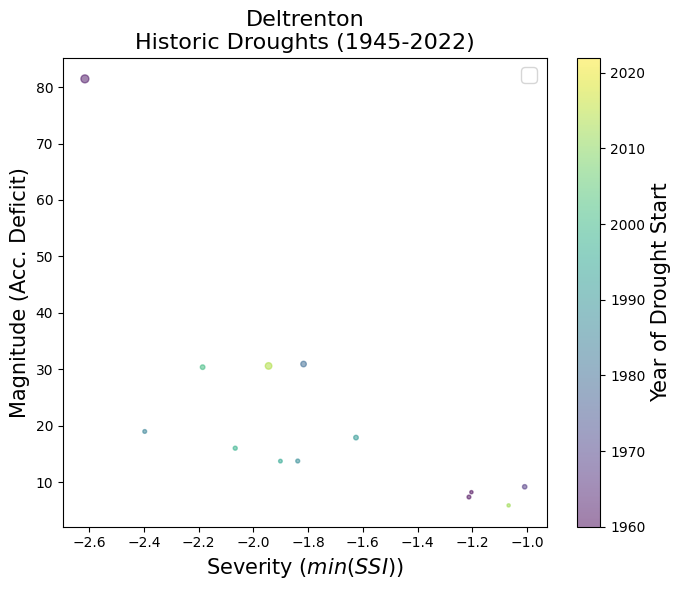

In [39]:
## Options

marker_keys = {'NYC Reservoirs' : 'o',
               'Upper Basin Reservoirs' : "^",
               'Mid-Basin Reservoirs' : 'D',
               'Lower Basin Reservoirs': "v"}


highlight_after_1970 = False
color_by_metric = 'date'
size_by_metric = 'duration'
plot_nodes = ['delTrenton']

fig, ax = plt.subplots(figsize = (7,6))

# Loop through nodes
for node in plot_nodes:
    node_drought_metrics = drought_metrics[drought_metrics['node']==node]
    xs = node_drought_metrics['severity']
    ys = -node_drought_metrics['magnitude']

    if color_by_metric == 'duration':
        marker_colors = node_drought_metrics[color_by_metric]
    elif color_by_metric == 'date':
        marker_colors = pd.to_datetime(node_drought_metrics['start']).dt.year

    # Assign marker shape
    if node in nyc_reservoirs:
        marker_shape = marker_keys['NYC Reservoirs']
    # elif node in upper_basin_reservoirs:
    #     marker_shape = marker_keys['Upper Basin Reservoirs']
    # elif node in mid_basin_reservoirs:
    #     marker_shape = marker_keys['Mid-Basin Reservoirs']
    # elif node in lower_basin_reservoirs:
    #     marker_shape = marker_keys['Lower Basin Reservoirs']
    else: 
        marker_shape = 'o'

    marker_sizes = node_drought_metrics[size_by_metric].values/2 if size_by_metric else 100
    marker_sizes = list(marker_sizes)

    p = ax.scatter(xs, ys,
                s = marker_sizes,
                marker=marker_shape,
                c=marker_colors, vmin=1960, vmax=2022, 
                alpha = 0.5)


if color_by_metric:
    plt.colorbar(p).set_label(label = 'Year of Drought Start',size=15)
plt.xlabel(r'Severity ($min(SSI)$)', fontsize = 15)
plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
if len(plot_nodes) == 1:
    plt.title(f'{plot_nodes[0].capitalize()}\nHistoric Droughts (1945-2022)', fontsize = 16)
else:
    plt.title(f'DRB Historic Droughts (1945-2022)', fontsize = 16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


In [37]:
node_drought_metrics

,start,end,duration,magnitude,severity,node
1,1985-02-28,1986-04-30,15,-19.611804,-2.384277,delTrenton
2,1988-03-31,1990-01-31,23,-17.754356,-1.621214,delTrenton
3,1991-03-31,1993-04-30,26,-29.805449,-2.321172,delTrenton
4,1995-04-30,1996-03-31,12,-12.663052,-1.705925,delTrenton
5,1999-01-31,2003-02-28,50,-48.997802,-2.389131,delTrenton
